In [3]:
import os
import shutil
import pandas as pd
import numpy as np 
import scipy
import shapely
from shapely import wkt
import tifffile as tiff
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch 
from matplotlib.patches import Polygon
import cv2
from PIL import Image
from skimage.transform import rescale
import skimage.color as color
import image_slicer
import glob
from sklearn.model_selection import train_test_split as sk_train_test_split

%matplotlib inline

In [4]:
# Code for interacting with the sat images
# Adapted from https://www.kaggle.com/gabrielaltay/polygons-over-images-and-5x5-mosaics/code
N_CHANNELS = {'3': 3, 'A': 8, 'M': 8, 'P': 1}


class SatImageManager:
    """
    Manager class wrapping code for interacting with the sat image dataset
    
    Parameters
    ----------
    data_dir: str
        Path to the data. Assumed the folder is default from kaggle download
        
    """

    def __init__(self, data_dir='data/'):
        self.data_dir = data_dir
        self.wkt_manager = WktManager(data_dir)
        self.gs_manager = GridSizeManager(data_dir)

        self.fnames3b = os.listdir(os.path.join(data_dir, 'three_band'))
        self.fnames16b = os.listdir(os.path.join(data_dir, 'sixteen_band'))
        
    def get_fname(self, image_id, band):
        """
        Get filename from image_id and band level
        """
        if band == '3':
            fname = '{}/three_band/{}.tif'.format(
                self.data_dir, image_id)
        elif band in ['A', 'M', 'P']:
            fname = '{}/sixteen_band/{}_{}.tif'.format(
                self.data_dir, image_id, band)
        else:
            raise ValueError('band must be one of ["3", "A", "M", "P"]')
        return fname

    def get_image_dimensions(self, image_id, band):
        """
        Get image dimention from id and band label 
        """
        fname = self.get_fname(image_id, band)
        with tiff.TiffFile(fname) as tfile:
            shape = tfile.pages[0].shape
        return shape

    def return_image(self, image_id, band):
        """
        Read image with the tifffile package
        """
        fname = self.get_fname(image_id, band)
        img = tiff.imread(fname)
        return img
    
    def return_polygon_patches(self, image_id):
        """
        Return a list of scaled polygon patches for given image
        """
        poly_dict = self.return_scaled_polygons(image_id)
        poly_list = []

        for p in poly_dict:
            for polygon in poly_dict[p]:
                poly_list.append(Polygon(np.array(polygon.exterior), color=plt.cm.Set1(p), lw=0, alpha=1))
                
        return poly_list
    
    def return_scaled_polygons(self, image_id):
        """
        Return dictionary of scaled polygons
        """
        poly_dict = self.wkt_manager.return_polygon_dict(image_id)
        _, w, h = self.get_image_dimensions(image_id, '3') 
        x_max, y_min = self.gs_manager.get_xmax_ymin(image_id)
        for p in poly_dict:
            w = w * (w/(w+1))
            h = h * (h/(h+1))

            x_scaler = w / x_max
            y_scaler = h / y_min
            poly_dict[p] = shapely.affinity.scale(poly_dict[p], xfact = x_scaler, yfact= y_scaler, origin=(0,0,0))
        return poly_dict
        
    def return_plottable_image(self, image_id, band):
        """
        Return image in plottable form
        """
        image = self.return_image(image_id, band)
        if band == '3':
            image = np.rollaxis(image, 0, 3)
            return self.stretch_8bit(image)
        else:
            # TODO do this for other band 
            return image     
            
    def return_side_by_side_figure(self, image_ids, band, save=False):
        """
        Convenience for plotting image and polygons side by side
        """
        for image_id in image_ids:
            polygons = self.return_polygon_patches(image_id)
            image = self.return_plottable_image(image_id, band)

            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
            ax = axes.ravel()
            ax[0].imshow(image)
            ax[0].set_title(image_id)
            ax[0].axis('off')
            
            ax[1].imshow(image)
            for p in polygons:
                ax[1].add_patch(p)
            ax[1].set_title(image_id + 'labeled')
            ax[1].axis('off')
            plt.tight_layout()
            
    def pansharpen(self, image_id, method='browley', W=0.1, all_data=False):
        """
        Adapted from https://www.kaggle.com/resolut/panchromatic-sharpening
        Apply panchromatic sharpening to given image
        http://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/fundamentals-of-panchromatic-sharpening.htm
        """
        m = self.return_image(image_id, 'M')
        pan = self.return_image(image_id, 'P')
        
        # get m_bands
        rgbn = np.empty((m.shape[1], m.shape[2], 4)) 
        rgbn[:,:,0] = m[4,:,:] # red
        rgbn[:,:,1] = m[2,:,:] # green
        rgbn[:,:,2] = m[1,:,:] # blue
        rgbn[:,:,3] = m[6,:,:] # NIR-1

        # scaled them
        rgbn_scaled = np.empty((m.shape[1]*4, m.shape[2]*4, 4))

        for i in range(4):
            img = rgbn[:,:,i]
            scaled = rescale(img, (4,4))
            rgbn_scaled[:,:,i] = scaled

        # check size and crop for pan band
        if pan.shape[0] < rgbn_scaled.shape[0]:
            rgbn_scaled = rgbn_scaled[:pan.shape[0],:, :]
        else:
            pan = pan[:rgbn_scaled.shape[0], :]

        if pan.shape[1] < rgbn_scaled.shape[1]:
            rgbn_scaled = rgbn_scaled[:,:pan.shape[1], :]
        else:
            pan = pan[:,:rgbn_scaled.shape[1]]

        R = rgbn_scaled[:,:,0]
        G = rgbn_scaled[:,:,1]
        B = rgbn_scaled[:,:,2]
        I = rgbn_scaled[:,:,3]

        image = None

        if method == 'simple_browley':
            all_in = R+G+B
            prod = np.multiply(all_in, pan)

            r = np.multiply(R, pan/all_in)[:, :, np.newaxis]
            g = np.multiply(G, pan/all_in)[:, :, np.newaxis]
            b = np.multiply(B, pan/all_in)[:, :, np.newaxis]

            image = np.concatenate([r,g,b], axis=2)

        if method == 'sample_mean':
            r = 0.5 * (R + pan)[:, :, np.newaxis]
            g = 0.5 * (G + pan)[:, :, np.newaxis]
            b = 0.5 * (B + pan)[:, :, np.newaxis]

            image = np.concatenate([r,g,b], axis=2)

        if method == 'esri':
            ADJ = pan-rgbn_scaled.mean(axis=2) 
            r = (R + ADJ)[:, :, np.newaxis]
            g = (G + ADJ)[:, :, np.newaxis]
            b = (B + ADJ)[:, :, np.newaxis]
            i = (I + ADJ)[:, :, np.newaxis]

            image = np.concatenate([r,g,b,i], axis=2)

        if method == 'browley':
            DNF = (pan - W*I)/(W*R+W*G+W*B)

            r = (R * DNF)[:, :, np.newaxis]
            g = (G * DNF)[:, :, np.newaxis]
            b = (B * DNF)[:, :, np.newaxis]
            i = (I * DNF)[:, :, np.newaxis]

            image = np.concatenate([r,g,b,i], axis=2)

        if method == 'hsv':
            hsv = color.rgb2hsv(rgbn_scaled[:,:,:3])
            hsv[:,:,2] = pan - I*W
            image = color.hsv2rgb(hsv)

        if all_data:
            return rgbn_scaled, image, I
        else:
            return image

    def stretch_8bit(self, bands, lower_percent=2, higher_percent=98):
        """
        Matplotlib doesn't support viewing 16 bit images, so we convert
        to 8 bit here. Note: Some information will be lost
        """
        out = np.zeros_like(bands).astype(np.float32)
        for i in range(3):
            a = 0 
            b = 1 
            c = np.percentile(bands[:,:,i], lower_percent)
            d = np.percentile(bands[:,:,i], higher_percent)        
            t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
            t[t<a] = a
            t[t>b] = b
            out[:,:,i] =t
        return out.astype(np.float32)


class WktManager:
    """Handles the training labels (polygons in wkt format)"""

    def __init__(self, data_dir='data/', fname='train_wkt_v4.csv'):
        path = os.path.join(data_dir, fname)
        self.df = pd.read_csv(path)
        self.image_ids = self.df['ImageId'].unique()

    def return_image_df(self, image_id):
        """
        Get data frame from image
        """
        bmask = self.df['ImageId']==image_id
        return self.df[bmask]

    def return_polygon_dict(self, image_id):
        """
        Return polygon dict for given image from the data frame
        """
        polygon_dict = {}
        image = self.return_image_df(image_id)
        for c_type in image.ClassType.unique():
            polygon_dict[c_type] = wkt.loads(image[image.ClassType == c_type].MultipolygonWKT.values[0])
        return polygon_dict
    
    
class GridSizeManager:
    """Handles the geo-coordinates from the grid sizes file."""

    def __init__(self, data_dir='data/', fname='grid_sizes.csv'):
        path = os.path.join(data_dir, fname)
        self.df = pd.read_csv(
            path, names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

    def get_xmax_ymin(self, image_id):
        """
        Get xmax and ymin for polygon scaling
        """
        bmask = self.df['ImageId']==image_id
        xmax_ymin = self.df.loc[bmask, ['Xmax', 'Ymin']].iloc[0].to_dict()
        return xmax_ymin['Xmax'], xmax_ymin['Ymin']


In [5]:
def generate_training_data(im_manager, save_path, dpi=1200, method='hsv', W=0.1):
    """
    Generate A-B traning data. Creates folders A and B and save path and puts
    generated images into it.
    """
    a_path = os.path.join(save_path, 'A')
    b_path = os.path.join(save_path, 'B')
    
    overwrite_folder_at_path(a_path)
    overwrite_folder_at_path(b_path)
    
    for image_id in im_manager.wkt_manager.image_ids:
        
        # Sharpened image
        sharpened = im_manager.pansharpen(image_id, method=method, W=W) 
        
        # Generate the map figure
        fig = plt.figure(figsize=(sharpened.shape[0]/dpi,sharpened.shape[1]/dpi), dpi=dpi)
        im = plt.imshow(im_manager.stretch_8bit(sharpened), aspect='auto')
        plt.axis('off')
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        plt.savefig(os.path.join(a_path, image_id + '.png'), bbox_inches='tight', pad_inches=0, dpi=dpi)
        plt.close(fig)

        # Generate the poly figure
        fig = plt.figure(figsize=(sharpened.shape[0]/dpi,sharpened.shape[1]/dpi), dpi=dpi)
        im = plt.imshow(np.zeros_like(sharpened), aspect='auto')
        ax = fig.add_subplot(111)
        
        polygons = im_manager.return_polygon_patches(image_id)
        for p in polygons:
            ax.add_patch(p)
        plt.axis('off')
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        plt.savefig(os.path.join(b_path, image_id + '.png'), bbox_inches='tight', pad_inches=0, dpi=dpi)
        plt.close(fig)

        
def plot_image_figure(im_manager, image_id):
    """
    Convenience function for plotting an image
    """
    sharpened = im_manager.pansharpen(image_id, method='hsv', W=0.1)
    fig = plt.figure(figsize=(50, 50))
    im = plt.imshow(im_manager.stretch_8bit(sharpened), aspect='auto')
    plt.axis('off')

def plot_polygon_figure(im_manager, image_id, image_dim, save_path=''):
    """
    Convenience function for plotting polygon images
    """
    fig = plt.figure(figsize=(50,50))
    plt.imshow(np.zeros(image_dim), aspect='auto')
    ax = fig.add_subplot(111)
    # Plot polygons
    polygons = im_manager.return_polygon_patches(image_id)
    for p in polygons:
        ax.add_patch(p)
    plt.axis('off')

        
def segment_training_data(save_path, num_segments=10):
    """
    Segment original images into equal slices. Saves the segments into A/sliced and B/sliced
    """
    # Path for images created by generate_training_data
    a_path = os.path.join(save_path, 'A')
    b_path = os.path.join(save_path, 'B')
    
    # Path for sliced images
    a_slice_path = os.path.join(a_path, 'sliced')
    b_slice_path = os.path.join(b_path, 'sliced')

    # Write slice path
    overwrite_folder_at_path(a_slice_path)
    overwrite_folder_at_path(b_slice_path)

    file_names = []
    
    # Assume the file names in 
    # both directories match exactly
    # so we only scan the directory once
    for file in os.listdir(a_path):
        if file.endswith('.png'):
            file_names.append(file)
    
    for f in file_names:
        # Slice and save to slice path
        a_tiles = image_slicer.slice(os.path.join(a_path, f), num_segments, save=False)
        b_tiles = image_slicer.slice(os.path.join(b_path, f), num_segments, save=False)
        # Save with prefix of previous filename stipped of .png
        image_slicer.save_tiles(a_tiles, prefix=f[:-4], directory=a_slice_path)
        image_slicer.save_tiles(b_tiles, prefix=f[:-4], directory=b_slice_path)
        
def train_test_split(save_path, pic_dir='sliced', valid_ratio=0.1, test_ratio=0.1):
    """
    Generate train test split from segmented training data. Saves the splites into
    A/train A/test A/valid
    B/train B/test/ B/valid
    This format allows pix2pix to generate a valid dataset from the images
    """
    a_path = os.path.join(save_path, 'A')
    b_path = os.path.join(save_path, 'B')
    
    a_slice_path = os.path.join(a_path, pic_dir)
    b_slice_path = os.path.join(b_path, pic_dir)
    
    a_train_path = os.path.join(a_path, 'train')
    a_test_path = os.path.join(a_path, 'test')
    a_valid_path = os.path.join(a_path, 'valid')
    
    b_train_path = os.path.join(b_path, 'train')
    b_test_path = os.path.join(b_path, 'test')
    b_valid_path = os.path.join(b_path, 'valid')
    
    overwrite_folder_at_path(a_train_path)
    overwrite_folder_at_path(a_test_path)
    overwrite_folder_at_path(a_valid_path)
    
    overwrite_folder_at_path(b_train_path)
    overwrite_folder_at_path(b_test_path)
    overwrite_folder_at_path(b_valid_path)
    
    a_file_names = []
    b_file_names = []
    
    for file in os.listdir(a_slice_path):
        if file.endswith('.png'):
            a_file_names.append(file)
    
    for file in os.listdir(b_slice_path):
        if file.endswith('.png'):
            b_file_names.append(file)
    
    a_file_names = sorted(a_file_names)
    b_file_names = sorted(b_file_names)
    
    a_train, a_test, b_train, b_test = sk_train_test_split(a_file_names, b_file_names, test_size=test_ratio)
    a_train, a_val, b_train, b_val = sk_train_test_split(a_train, b_train, test_size=valid_ratio)
    
    move_files(a_slice_path, a_train_path, a_train)
    move_files(a_slice_path, a_valid_path, a_val)
    move_files(a_slice_path, a_test_path, a_test)
    move_files(b_slice_path, b_train_path, b_train)
    move_files(b_slice_path, b_valid_path, b_val)
    move_files(b_slice_path, b_test_path, b_test)


def move_files(src, dst, filenames):
    """
    move an array of filenames from a src to dst directory
    """
    for f in filenames:
        shutil.move(os.path.join(src, f), os.path.join(dst, f))
    
        
def overwrite_folder_at_path(path):
    """
    Danger! Hard overwrite of a directoy at given path
    """
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    

In [39]:
# Segement Training Data Generation
save_path = 'training_data'
im_manager = SatImageManager()
generate_training_data(im_manager, save_path)
segment_training_data(save_path)
train_test_split(save_path, pic_dir='')

In [ ]:
# Panchromatic sharpening crossval
methods = ['esri', 'browley', 'hsv']
W_vals = [0.1, 0.2, 0.3, 0.4]
save_path = 'training_data'
im_manager = SatImageManager()
for W in W_vals:
    generate_training_data(im_manager, save_path + '_' + str(W), method='hsv', W=W)
#     segment_training_data(save_path + '_' + m)
    train_test_split(save_path, pic_dir='')

/home/calvin/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/calvin/miniconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/calvin/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/color/colorconv.py:278: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]


In [20]:
im_manager = SatImageManager()

sharpened = im_manager.pansharpen('6060_2_2', W=0.1) 


/home/calvin/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


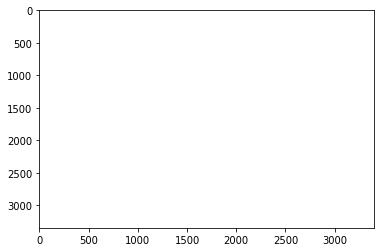

In [21]:
im = plt.imshow(im_manager.stretch_8bit(sharpened), aspect='auto')


In [23]:
sharpened.shape

(3348, 3404, 4)